# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


In [4]:
from __future__ import print_function, division
import os
import zipfile
import pylab as pl
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


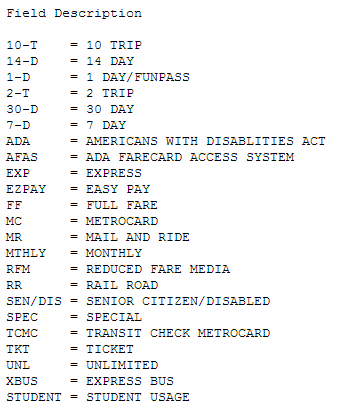

In [224]:
from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

In [8]:
os.environ["PUIDATA"] = '%s/PUIdata'%os.getenv('HOME')

In [174]:
MTA_Fare = zipfile.ZipFile(os.getenv('PUIDATA') + '/MTA_Fare.zip')
MTA_Fare.extractall(os.getenv('PUIDATA'))

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [5]:
mta = np.load(os.getenv('PUIDATA') + '/MTA_Fare.npy')
mta = mta.astype(float)
mta[mta==-1] = np.nan
print('MTA Fare array shape:', mta.shape)
#600 station, each station has data about 23 type cards with 194 weeks
print('MTA Fare array shape summed over all ride types', np.nansum(mta, axis=1).shape)
#600 station in 194 weeks, data shows total number of all ride

MTA Fare array shape: (600, 23, 194)
MTA Fare array shape summed over all ride types (600, 194)


create a "ride types" list based on the metadata I was given

In [6]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


The maximum number of swipes occured in the 170th station with mean 260035.77


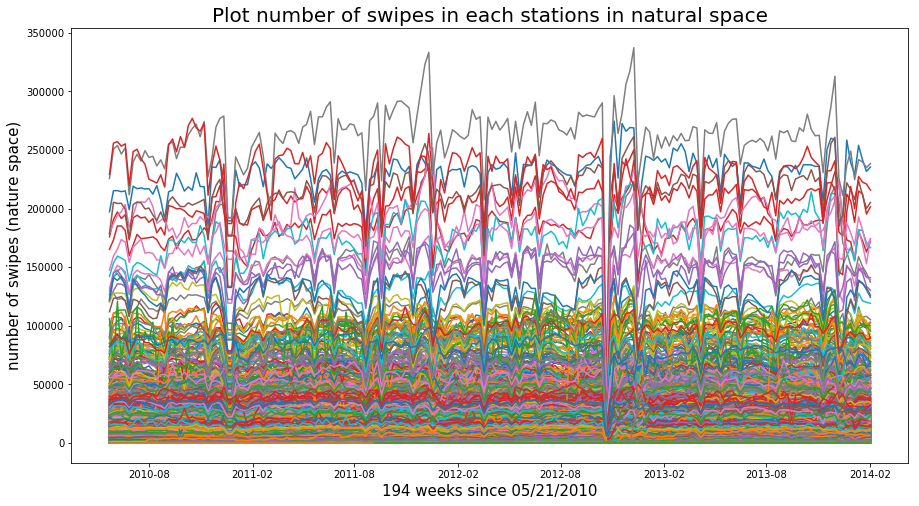

In [315]:
#calculate 194 weeks started from 05/21/2010
date = pd.date_range(start='05/21/2010', periods=194, freq='W')
date = np.transpose([np.array(date)])

#plot number of swipes(23 types) in each stations(600 total) during 194 weeks
plt.figure(figsize=(15,8))
max_station = np.nanmean(mta[0][0])
n_max = 0
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        plt.plot(date, mta[i][j])
        if (np.nanmean(mta[i][j])>max_station).any():
            n_max = (i,j)
            max_station = np.nanmean(mta[i][j])
print('The maximum number of swipes occured in the %sth station from type %s with mean %.2f'
      %((n_max+1), max_station))
    
plt.title('Plot number of swipes in each stations in natural space', fontsize=20)
plt.xlabel('194 weeks since 05/21/2010', fontsize=15)
plt.ylabel('number of swipes (nature space)', fontsize=15)

**figure 1:** Plot the number of swipes(23 types) in each station (600 in total) during these 194 weeks. It seems that the number of swipes under 100000 tend to happend more. In addition, all stations have the similar swipe pattern against the time. It is clear that a station has the maximum amount of swiping than other station. After calculation, this station is the 170th station with the mean 260035 times of swiping.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


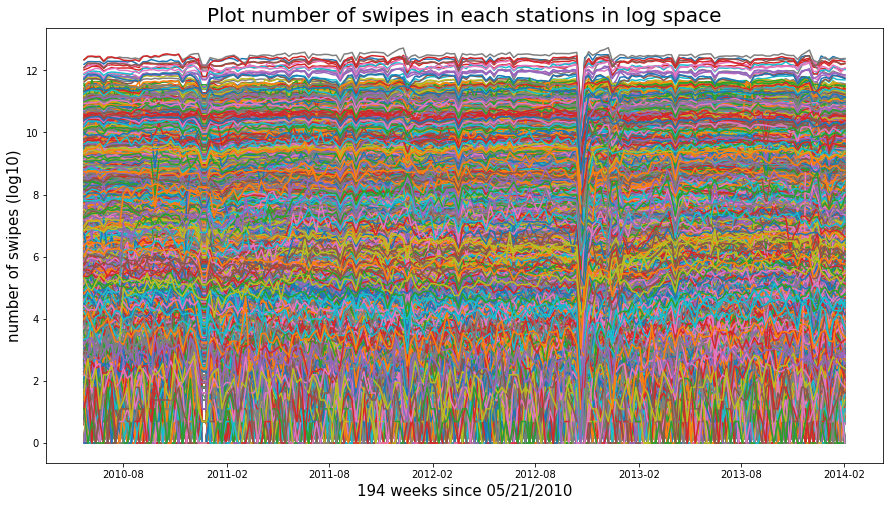

In [316]:
#plot number of swipes(23 types) in each stations(600 total) during 194 weeks
plt.figure(figsize=(15,8))
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        plt.plot(date, np.log(mta[i][j]))
    
plt.title('Plot number of swipes in each stations in log space', fontsize=20)
plt.xlabel('194 weeks since 05/21/2010', fontsize=15)
plt.ylabel('number of swipes (log10)', fontsize=15)

**Figure 2:** time series for all ride types and all stations in log10 space. The graph is spread more evenly than the nature base. Although personally I feel nature space is more beautiful.

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [232]:
mta_bydate = np.nansum(np.nansum(mta, axis=0), axis=0)
mta_bydate.shape

(194,)

In [235]:
print('Mean swipes by date %.2f'%(np.nanmean(mta_bydate)))
print('standard deviation by date %.2f'%(np.nanstd(mta_bydate)))
threshold = [np.nanmean(mta_bydate) + 3*np.nanstd(mta_bydate), np.nanmean(mta_bydate) - 3*np.nanstd(mta_bydate)]
print('3-sigma threshold {:.2f} {:.2f}'.format(*threshold))

Mean swipes by date 29781349.87
standard deviation by date 2983960.42
3-sigma threshold 38733231.14 20829468.61


In [569]:
date.shape

(194, 1)

In [575]:
np.transpose([mta_bydate]).shape

(194, 1)

Text(0,0.5,'number of swipes (log10)')

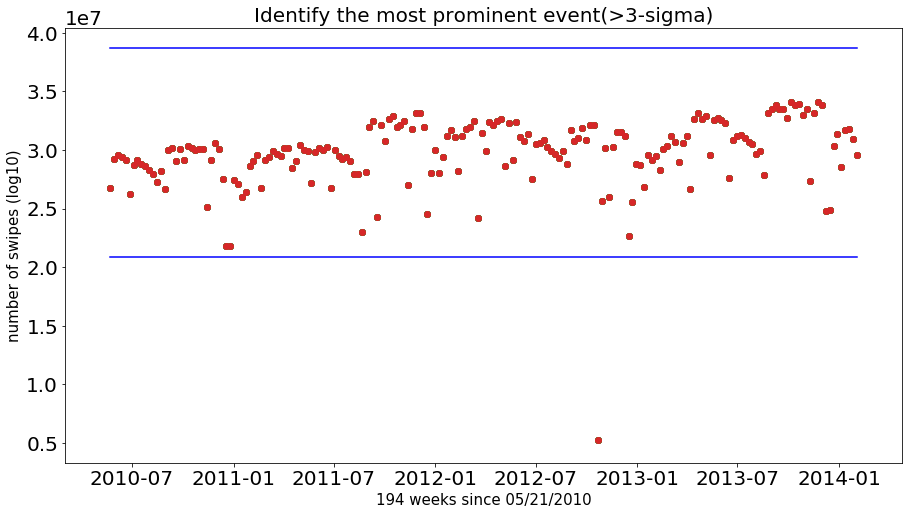

In [251]:
plt.figure(figsize=(15,8))
for i in range(mta.shape[2]):
    ax=plt.scatter(date, np.transpose([mta_bydate]))
plt.plot([min(date), max(date)], [threshold[0], threshold[0]], color='blue')
plt.plot([min(date), max(date)], [threshold[1], threshold[1]], color='blue')

plt.title('Identify the most prominent event(>3-sigma)', fontsize=20)
plt.xlabel('194 weeks since 05/21/2010', fontsize=15)
plt.ylabel('number of swipes (log10)', fontsize=15)

**Figure3:** Plotting 3 sigma to identify the most prominent event. The points indicate the sum of number of swipes in all station, based on 194 weeks. The blue lines plot the up and low thershold for 3 sigma range. It is obvious that between 2017/07 and 2013/01 something happended, resulting significant low swiping number in that day.

#### Possible event: Hurricane Sandy's effect in 2012/10.

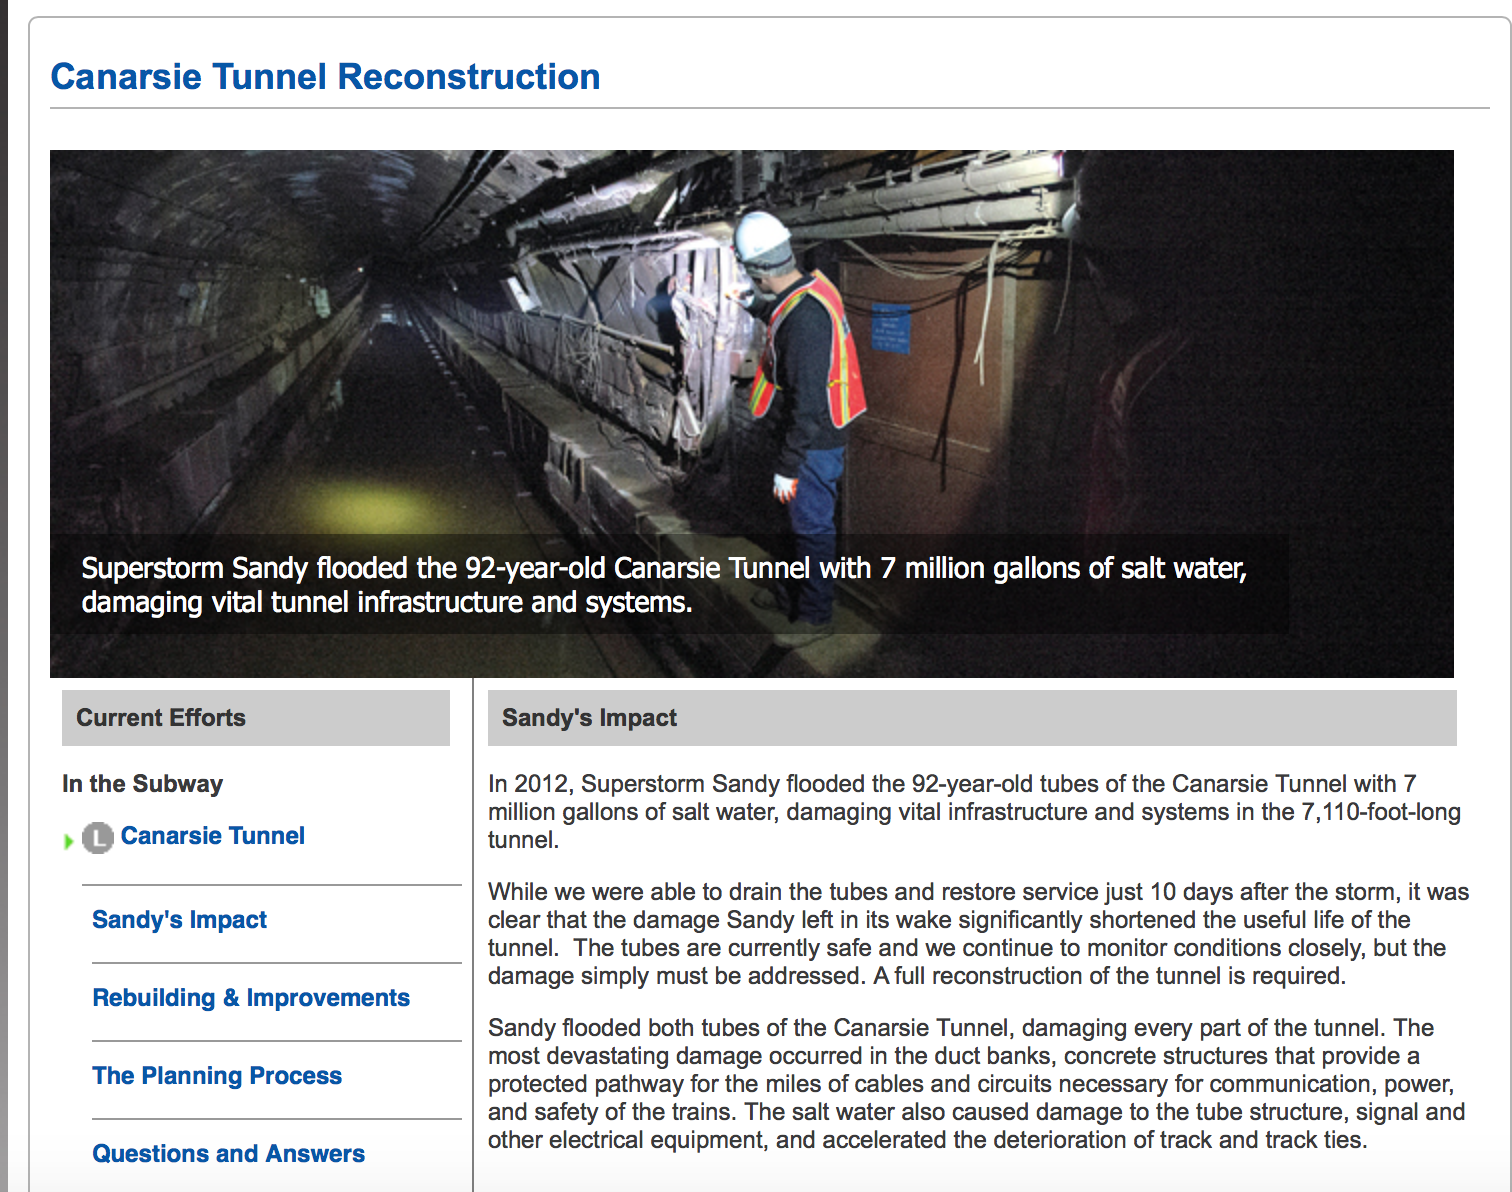

In [252]:
Image(filename = "Sandy.png")

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [253]:
#sum to leave 23 ride type:
mta_type = np.nansum(mta, axis=0)
mta_typedf = pd.DataFrame(mta_type).dropna()
mta_typedf.shape

(23, 194)

0 10t
The fractional chage over time of 10t ride is 0.95
1 14d
The fractional chage over time of 14d ride is 0.74
2 1d
The fractional chage over time of 1d ride is 0.85
3 2t
The fractional chage over time of 2t ride is 1.02
4 30d
The fractional chage over time of 30d ride is 0.89
5 7d
The fractional chage over time of 7d ride is 0.69
6 ada
The fractional chage over time of ada ride is 1.07
7 afas
The fractional chage over time of afas ride is 4811.68
8 exp
The fractional chage over time of exp ride is 94171.31
9 ez
The fractional chage over time of ez ride is 510718.48
10 ff
The fractional chage over time of ff ride is 1.15
11 mc
The fractional chage over time of mc ride is 0.80
12 mr
The fractional chage over time of mr ride is 0.00
13 month
The fractional chage over time of month ride is 1.62
14 rfm
The fractional chage over time of rfm ride is 1.51
15 rr
The fractional chage over time of rr ride is 0.38
16 sen
The fractional chage over time of sen ride is 0.36
17 spec
The fractional

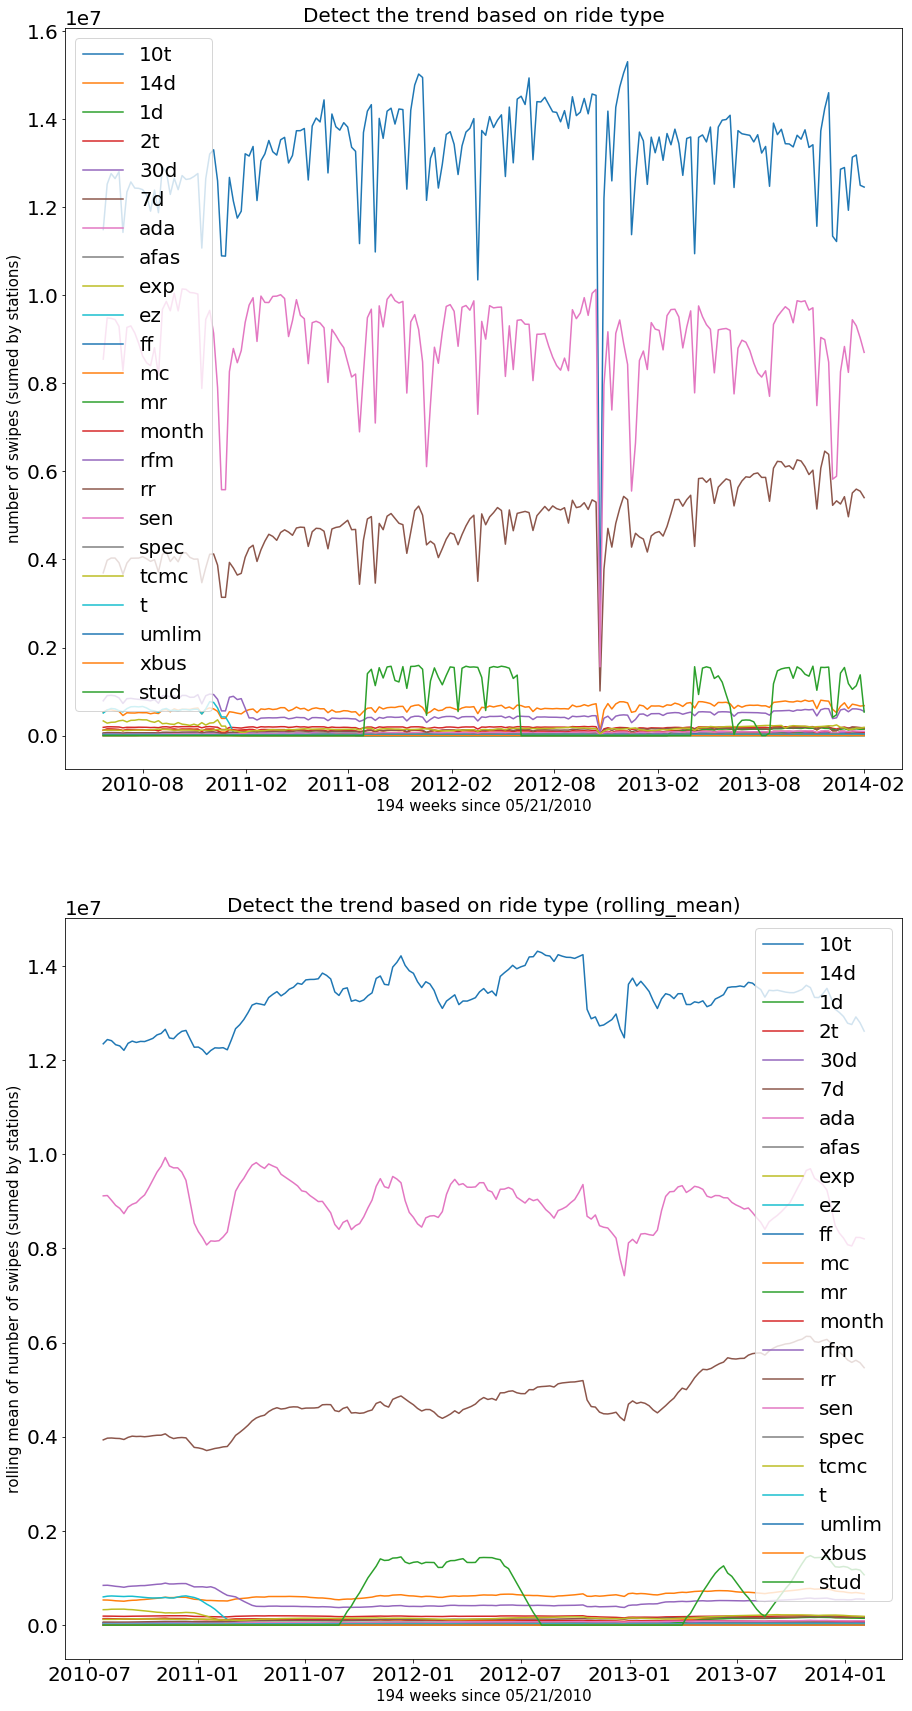

In [302]:
fig = plt.figure(figsize=(15,30))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for i in range(mta_type.shape[0]):
    ax1.plot(date, mta_typedf.iloc[i])
    type_rmean = mta_typedf.iloc[i].rolling(10).mean()
    ax2.plot(date, type_rmean)
    beg_mean = mta_typedf.iloc[i].rolling(10).mean()[10:20].mean()
    end_mean = mta_typedf.iloc[i].rolling(10).mean()[-10:].mean()
    print(i, ridetype[i])
    print('The fractional chage over time of {} ride is {:.2f}'
          .format(ridetype[i], (beg_mean/end_mean)))
        
ax1.set_title('Detect the trend based on ride type', fontsize=20)
ax1.set_xlabel('194 weeks since 05/21/2010', fontsize=15)
ax1.set_ylabel('number of swipes (sumed by stations)', fontsize=15)
ax1.legend(ridetype)

ax2.set_title('Detect the trend based on ride type (rolling_mean)', fontsize=20)
ax2.set_xlabel('194 weeks since 05/21/2010', fontsize=15)
ax2.set_ylabel('rolling mean of number of swipes (sumed by stations)', fontsize=15)
ax2.legend(ridetype)

**Figure 4**: Plotting the total number of swipes based on rideship type over 194 weeks. The top graph is based on the original data, while the bottom one uses a rolling mean for smoothing. In order to indicate the trend of data, I also print the ratio of the number of rides near the beginning to the number of rides near the end of the time series by averaging 10 rolling means.

#### Inteprete the graph

Text(0.5,1,'Detect the decrease trend for different rideship type')

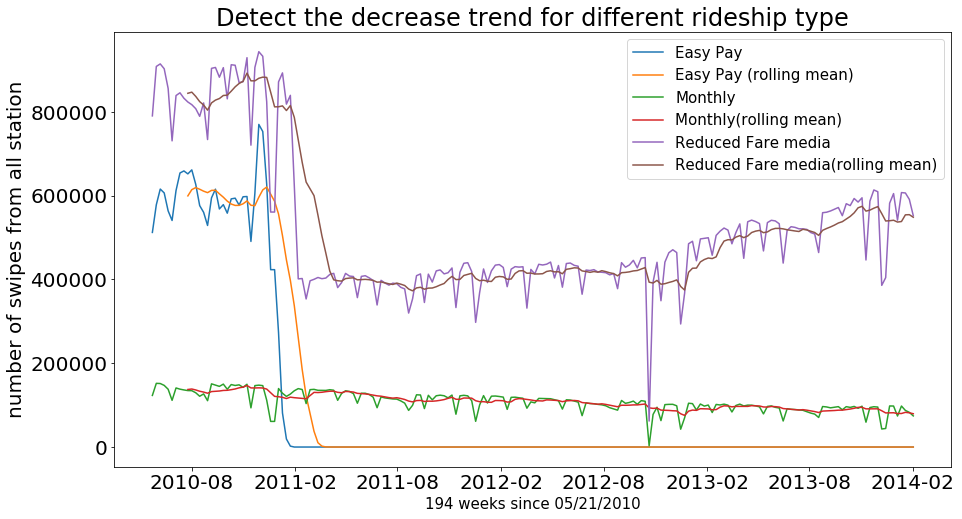

In [319]:
plt.figure(figsize=(15,8))
#9: 510718.48
plt.plot(date, mta_typedf.iloc[9], label='Easy Pay')
plt.plot(date, mta_typedf.iloc[9].rolling(10).mean(), label='Easy Pay (rolling mean)')
#13:1.62
plt.plot(date, mta_typedf.iloc[13], label='Monthly')
plt.plot(date, mta_typedf.iloc[13].rolling(10).mean(), label='Monthly(rolling mean)')
#14:1.51
plt.plot(date, mta_typedf.iloc[14], label='Reduced Fare media')
plt.plot(date, mta_typedf.iloc[14].rolling(10).mean(), label='Reduced Fare media(rolling mean)')
plt.legend(fontsize=15)
plt.xlabel('194 weeks since 05/21/2010', fontsize=15)
plt.ylabel('number of swipes from all station')
plt.title('Detect the decreased trend rideship type')

**Figure 5**: Detect the decreased trend of the usage of different ridetype. The Easy Pay has huge decreased ratio (510718.4), which may because this kind of type cancelled after 2011 so the mean of end period nearly 0. Except this extreme value, the next steepst decreased types are "montly" and "Reduced Fare Media", while the former shows a structure change while the latter shows a smoothing change. 

Text(0.5,1,'Detect the 0 change type')

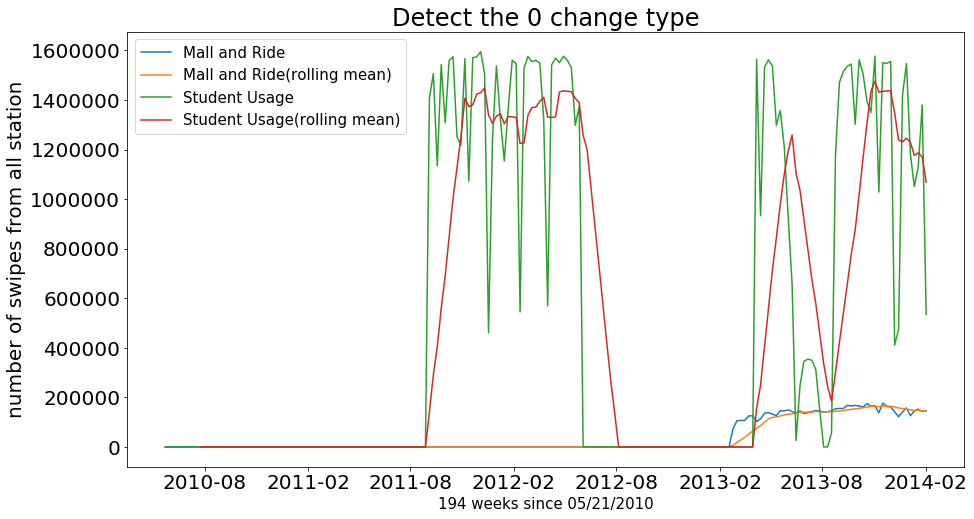

In [322]:
plt.figure(figsize=(15,8))
plt.plot(date, mta_typedf.iloc[12], label='Mall and Ride')
plt.plot(date, mta_typedf.iloc[12].rolling(10).mean(), label='Mall and Ride(rolling mean)')

plt.plot(date, mta_typedf.iloc[22], label='Student Usage')
plt.plot(date, mta_typedf.iloc[22].rolling(10).mean(), label='Student Usage(rolling mean)')
plt.legend(fontsize=15)
plt.xlabel('194 weeks since 05/21/2010', fontsize=15)
plt.ylabel('number of swipes from all station')
plt.title('Detect the 0 change type')

**Figure 6**: It is interested that the "Mall and Ride" and "Student" type shown a fraction ratio as 0. According to the graph, it may because these two types didn't constantly exist. The student type may only exist between 2011-2012 and 2013-2014, while the Mall and Ride type began at 2013.

Text(0.5,1,'Detect the increased change type')

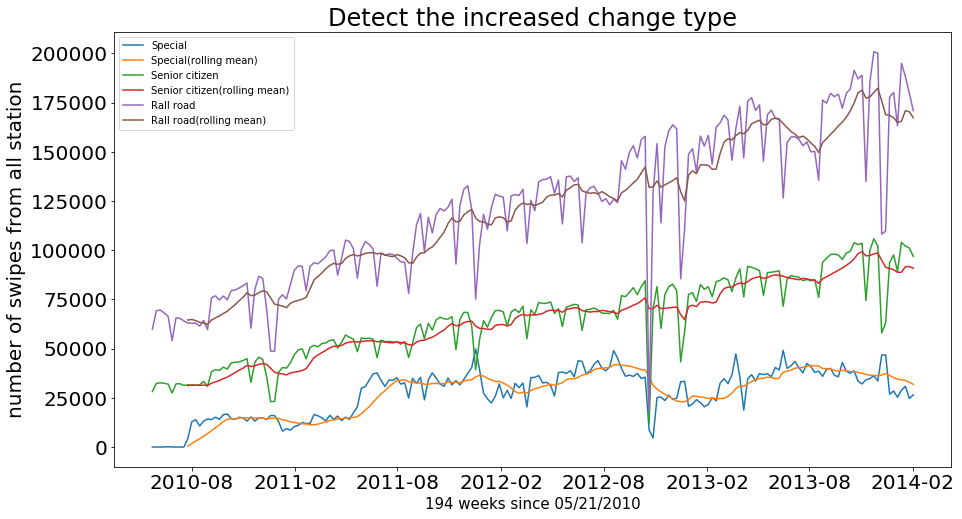

In [326]:
plt.figure(figsize=(15,8))
#17:0.22
plt.plot(date, mta_typedf.iloc[17], label='Special')
plt.plot(date, mta_typedf.iloc[17].rolling(10).mean(), label='Special(rolling mean)')
#16:0.36
plt.plot(date, mta_typedf.iloc[16], label='Senior citizen')
plt.plot(date, mta_typedf.iloc[16].rolling(10).mean(), label='Senior citizen(rolling mean)')
#15:0.38
plt.plot(date, mta_typedf.iloc[15], label='Rall road')
plt.plot(date, mta_typedf.iloc[15].rolling(10).mean(), label='Rall road(rolling mean)')
plt.legend(loc=2, fontsize=10)
plt.xlabel('194 weeks since 05/21/2010', fontsize=15)
plt.ylabel('number of swipes from all station')
plt.title('Detect the increased change type')

**Figure 7**: This figure shows three steepest inceased rideship type. They all seems have the smooth and steady change.

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [7]:
mta_rs = mta.reshape(600*23,194)
mta_rs.shape

(13800, 194)

#### time series mean divided by the mean of all time series for that station

In [83]:
#calculate the mean of each station
stationsmeans = []
for i in range(len(mta)):
    mean = np.nanmean(mta[i])
    stationsmeans.append(mean)
stationsmeans = np.asarray(stationsmeans)
stationsmeans.shape
#[stationsmeans.append(np.nanmean(mta[i])) for i in range(len(mta))] ??

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice


In [10]:
#time series mean divided by the mean of that station
ridemeans_norm = []
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        mean = np.nanmean(mta_rs[j])/stationsmeans[i]
        ridemeans_norm.append(mean)
ridemeans_norm = np.asarray(ridemeans_norm)
ridemeans_norm[:10]

array([  1.10015275e+01,   3.43298634e-01,   4.45648301e-02,
         1.38518125e-01,   5.50463576e-02,   3.76188253e+00,
         5.73809206e+00,   1.60983431e-03,   1.83494705e-01,
         8.09865979e-02])

####  time series standard deviation by the standard deviation of all time series for that station

In [11]:
#calculate the standard deviation of each station
stationsstd = []
for i in range(len(mta)):
    std = np.nanstd(mta[i])
    stationsstd.append(std)
stationsstd = np.asarray(stationsstd)
stationsstd.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux

(600,)

In [12]:
#time series standard deviation divided by the standard deviation of that station
ridestd_norm = []
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        std = np.nanstd(mta_rs[j])/stationsstd[i]
        ridestd_norm.append(std)
ridestd_norm = np.asarray(ridestd_norm)
ridestd_norm[:10]

array([ 1.2460216 ,  0.03584657,  0.0046675 ,  0.01313382,  0.00987946,
        0.41631811,  0.70333791,  0.00131435,  0.16239779,  0.06958021])

#### slope and intercept of a line fit to the standardized time series

In [13]:
#apply the label
label = np.asarray([np.arange(0,mta.shape[1])]*mta.shape[0]).flatten() 
label[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22,  0,  1,  2])

In [14]:
label_df = pd.DataFrame(np.transpose([label]))
label_df.rename(columns={0:'ridetype'}, inplace=True)
label_df.shape

(13800, 1)

In [67]:
tot_df = pd.merge(label_df, pd.DataFrame(mta_rs), left_index=True, right_index=True)
tot_df.dropna(inplace=True)
#totdf = pd.merge(totdf, tot_mean_std, left_index=True, right_index=True)
tot_df.head()

ridetype       0       1       2       3       4       5       6       7  \
46         0  3292.0  3429.0  3629.0  2808.0  3614.0  2601.0  2848.0  2798.0   
47         1   110.0    92.0   102.0    79.0    93.0    74.0    72.0    92.0   
48         2     7.0     6.0    13.0     7.0     5.0     7.0     7.0     6.0   
49         3    41.0    51.0    47.0    37.0    50.0    43.0    44.0    32.0   
50         4     0.0     0.0     0.0     0.0     1.0     1.0     0.0     0.0   

         8   ...       184     185     186     187     188     189     190  \
46  2888.0   ...    3506.0  2894.0  2679.0  3337.0  3599.0  3273.0  3418.0   
47    97.0   ...     192.0   167.0   160.0   180.0   204.0   166.0   191.0   
48     3.0   ...      21.0    17.0    18.0    20.0    19.0    13.0    19.0   
49    43.0   ...      25.0    18.0    24.0    20.0    25.0    29.0    31.0   
50     0.0   ...       2.0     1.0     1.0    10.0     8.0     6.0     5.0   

       191     192     193  
46  3746.0  3406.0  3217.0  
47   212.0   209.0   211.0  
48    26.0    20.0    22.0  
49    28.0    24.0    22.0  
50     5.0     6.0     0.0  

[5 rows x 195 columns]

In [68]:
tot_df.shape

(9174, 195)

In [102]:
label = tot_df['ridetype']

In [69]:
#clean the Nan for time series data
mta_tot = tot_df.drop(['ridetype'], axis=1)

In [70]:
mta_tot.dropna(inplace=True)
mta_tot
mta_tot.reset_index(inplace=True, drop=True)
mta_totT = mta_tot.T
mta_totT.shape

(194, 9174)

In [71]:
#calculate time series.mean and std for each type
totmean = np.nanmean(mta_tot, axis=1)
totstd = np.nanstd(mta_tot, axis=1)

In [72]:
totmean.shape

(9174,)

In [73]:
totmean[:10]

array([  3.54891753e+03,   1.44587629e+02,   1.79381443e+01,
         3.02577320e+01,   2.89690722e+00,   1.72666495e+03,
         1.25873711e+03,   3.86597938e-01,   4.62886598e+00,
         3.00618557e+01])

In [74]:
totstd[:10]

array([ 391.40042433,   43.60075488,    8.13711673,    9.80981872,
          4.23530701,  286.20893188,  182.35136007,    1.22685827,
         11.1163663 ,   67.14683317])

In [75]:
#Standardized the mean and std for each type
for i in range(mta_tot.shape[0]):
    mta_totT[i] = mta_totT[i].apply(lambda x: (x-totmean[i])/totstd[i])

Text(0,0.5,'standardized number of rides')

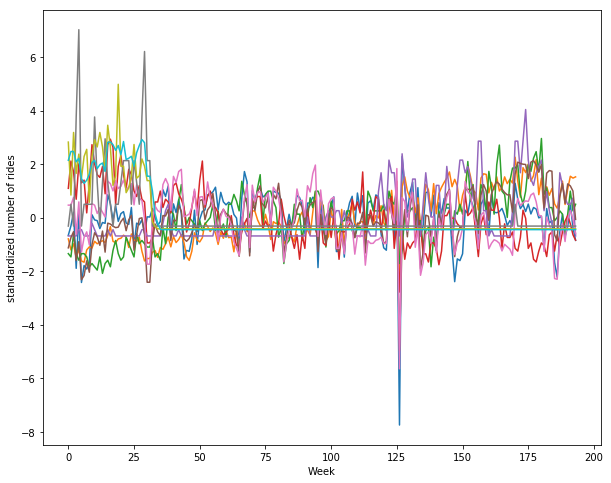

In [35]:
plt.figure(figsize=(10,8))
for i in range(10):
    plt.plot(mta_totT[i])
plt.xlabel('Week')
plt.ylabel('standardized number of rides')

**Figure 7**: This figure plots the standardized number of swipes, selecting the begining 10 records. The data seems to be randomly spread aroud 0, while all have the minimum amount around week 125.

In [76]:
mta_totT.shape

(194, 9174)

In [849]:
mta_totT.index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193],
      dtype='object', length=194)

In [165]:
#fit the line for each type, storing the intercept and slope
fitresults = []
for i in range(mta_totT.shape[1]):
    x = np.asarray(mta_totT[i].index, dtype=float)
    x = sm.add_constant(x)
    y = np.asarray(mta_totT[i])
    linermod = sm.OLS(y,x)
    fitresultsi = linermod.fit()
    fitresults.append(fitresultsi.params)
fitresults[:10]

[array([ -9.41656187e-03,   9.75809520e-05]),
 array([-1.45472894,  0.01507491]),
 array([-1.06906758,  0.01107842]),
 array([ 1.06717918, -0.01105885]),
 array([-1.0233822,  0.010605 ]),
 array([-0.87136895,  0.00902973]),
 array([ 0.57195705, -0.00592702]),
 array([ 0.74689658, -0.00773986]),
 array([ 1.04464787, -0.01082537]),
 array([ 1.10357884, -0.01143605])]

In [166]:
fitresults = pd.DataFrame(fitresults, columns=['intercept', 'slope'])
fitresults.head()

intercept     slope
0  -0.009417  0.000098
1  -1.454729  0.015075
2  -1.069068  0.011078
3   1.067179 -0.011059
4  -1.023382  0.010605

#### Train_test splite

In [167]:
ridemeans_norm1 = pd.DataFrame(ridemeans_norm)
ridestd_norm1 = pd.DataFrame(ridestd_norm)
mean_std_norm = pd.merge(ridemeans_norm2, ridestd_norm1, left_index=True, right_index=True, suffixes=['_mean','_std'])
mean_std_norm = mean_std_norm.iloc[tot_df.index]
mean_std_norm.reset_index(inplace=True, drop=True)
mean_std_norm.head()

0_mean      0_std
0  183.219112  21.522460
1    5.717285   0.619176
2    0.742181   0.080622
3    2.306877   0.226860
4    0.916740   0.170647

In [356]:
X = pd.merge(fitresults, mean_std_norm, left_index=True, right_index=True)
X.head()

intercept     slope      0_mean      0_std
0  -0.009417  0.000098  183.219112  21.522460
1  -1.454729  0.015075    5.717285   0.619176
2  -1.069068  0.011078    0.742181   0.080622
3   1.067179 -0.011059    2.306877   0.226860
4  -1.023382  0.010605    0.916740   0.170647

In [357]:
x_train, x_test, y_train, y_test = train_test_split(X, label, test_size=0.33, random_state=42)

In [358]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6146, 4), (3028, 4), (6146,), (3028,))

#### git rid of infinite and nan

In [359]:
(~np.isfinite(x_train)).sum(),(~np.isfinite(x_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(intercept    1007
 slope        1007
 0_mean          0
 0_std           0
 dtype: int64, intercept    507
 slope        507
 0_mean         0
 0_std          0
 dtype: int64, 0, 0)

In [360]:
x_train['intercept'][~np.isfinite(x_train['intercept'])] = x_train['intercept'].mean();
x_train['slope'][~np.isfinite(x_train['slope'])] = x_train['slope'].mean()
x_test['intercept'][~np.isfinite(x_test['intercept'])] = x_test['intercept'].mean()
x_test['slope'][~np.isfinite(x_test['slope'])] = x_test['slope'].mean()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/generic.py:4485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [361]:
(np.isnan(x_train)).sum(),(np.isnan(x_test)).sum(),(np.isnan(y_train)).sum(),(np.isnan(y_test )).sum()

(intercept    0
 slope        0
 0_mean       0
 0_std        0
 dtype: int64, intercept    0
 slope        0
 0_mean       0
 0_std        0
 dtype: int64, 0, 0)

In [362]:
rf = rfc(n_estimators=100)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [363]:
y_pred = rf.predict(x_test)

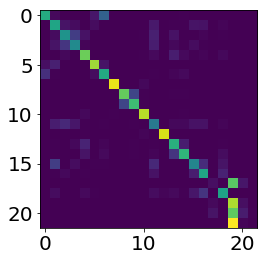

In [364]:
imshow(confusion_matrix(y_test, y_pred))

**Figure 8:** Image the confusion matrix to evaluate the accuracy of a classification. The x-axis represents the prediction of the rideshipt type, while the y-axix represents the true rideship type. An bright line shown in the graph indicates there are some good degree of accurate prediction. However, there is a little mass at right bottom corner around 19, which indicates a little mass of prediction at the end of the data.

In [182]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.80      0.60      0.69       151
        14d       0.49      0.58      0.53       134
         1d       0.55      0.55      0.55       139
         2t       0.57      0.54      0.56       126
        30d       0.70      0.75      0.72       146
         7d       0.85      0.82      0.83       154
        ada       0.60      0.73      0.66       123
       afas       0.99      0.98      0.99       146
        exp       0.82      0.74      0.78       147
         ez       0.74      0.81      0.77       134
         ff       0.93      0.96      0.94       137
         mc       0.47      0.47      0.47       123
         mr       0.99      0.98      0.98       142
      month       0.63      0.72      0.67       130
        rfm       0.78      0.69      0.73       140
         rr       0.56      0.43      0.49       146
        sen       0.58      0.69      0.63       125
       spec       0.38      0.05      0.09   

**Interpretation:** The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples. The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes, where an F-beta score reaches its best value at 1 and worst score at 0. The support is the number of samples of the true response that lie in that class. The last line gives a weighted average of precision, recall and f1-score where the weights are the support values.

In [183]:
rf.feature_importances_

array([ 0.20955953,  0.2081712 ,  0.32325409,  0.25901518])

**Interpretation:** This give the evaluation of the importance of features. The higher the more important. In 4 features, the most important feature for prediction is the 3rd feature, which is "time series mean divided by the mean of all time series for that station".

## Build a model that uses as input features each time stamp (194 features) :


In [186]:
mta_tot.head()

0         1         2         3         4         5         6    \
0 -0.656406 -0.306381  0.204605 -1.892991  0.166281 -2.421861 -1.790794   
1 -0.793281 -1.206117 -0.976764 -1.504277 -1.183182 -1.618954 -1.664825   
2 -1.344229 -1.467122 -0.606867 -1.344229 -1.590016 -1.344229 -1.344229   
3  1.095053  2.114439  1.706685  0.687298  2.012501  1.298930  1.400869   
4 -0.683990 -0.683990 -0.683990 -0.683990 -0.447880 -0.447880 -0.683990   

        7         8         9      ...          184       185       186  \
0 -1.918540 -1.688597  0.107518    ...    -0.109651 -1.673267 -2.222577   
1 -1.206117 -1.091440 -1.137311    ...     1.087421  0.514036  0.353489   
2 -1.467122 -1.835803 -1.712909    ...     0.376283 -0.115292  0.007602   
3  0.177605  1.298930  2.726072    ...    -0.535966 -1.249537 -0.637905   
4 -0.683990 -0.683990 -0.211769    ...    -0.211769 -0.447880 -0.447880   

        187       188       189       190       191       192       193  
0 -0.541434  0.127957 -0.704949 -0.334485  0.503532 -0.365144 -0.848025  
1  0.812196  1.362645  0.491101  1.064485  1.546129  1.477322  1.523193  
2  0.253389  0.130495 -0.606867  0.130495  0.990751  0.253389  0.499176  
3 -1.045660 -0.535966 -0.128212  0.075666 -0.230150 -0.637905 -0.841782  
4  1.677114  1.204893  0.732672  0.496562  0.496562  0.732672 -0.683990  

[5 rows x 194 columns]

In [353]:
X2 = mta_tot

In [212]:
x2_train, x2_test, y2_train, y2_test = train_test_split(X2, label, test_size=0.33, random_state=42)

In [213]:
x2_train.shape, x2_test.shape, y2_train.shape, y2_test.shape

((6146, 194), (3028, 194), (6146,), (3028,))

In [214]:
x2_train[~np.isfinite(x2_train)] = np.nanmean(ridemeans_norm)
x2_test[~np.isfinite(x2_test)] = np.nanmean(ridemeans_norm)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/frame.py:2392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.where(-key, value, inplace=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [215]:
rf2 = rfc(n_estimators=100)
rf2.fit(x2_train, y2_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [216]:
y2_pred = rf2.predict(x2_test)

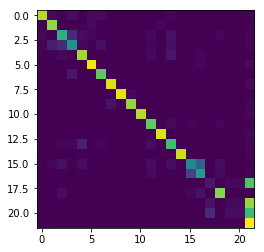

In [217]:
imshow(confusion_matrix(y2_test, y2_pred))

**Figure 9:** Image the confusion matrix to evaluate the accuracy of a classification. The x-axis represents the prediction of the rideshipt type, while the y-axix represents the true rideship type. An bright line shown in the graph indicates there are some good degree of accurate prediction. However, there is a little mass at right bottom corner after 20, which indicates a little mass of prediction at the end of the data. Comparing with last model, this model mass later than the last model, so may have more correct classification.

In [219]:
print(classification_report(y2_test, y2_pred))

             precision    recall  f1-score   support

          0       0.94      0.87      0.91       151
          1       0.85      0.92      0.88       134
          2       0.71      0.68      0.70       139
          3       0.68      0.60      0.63       126
          4       0.80      0.86      0.83       146
          5       0.91      0.94      0.92       154
          6       0.89      0.90      0.90       123
          7       0.95      0.96      0.95       146
          8       0.99      0.97      0.98       147
          9       0.98      0.93      0.95       134
         10       0.99      0.96      0.97       137
         11       0.82      0.91      0.86       123
         12       0.99      0.98      0.98       142
         13       0.73      0.78      0.76       130
         14       0.99      0.97      0.98       140
         15       0.65      0.49      0.55       146
         16       0.59      0.66      0.62       125
         17       0.27      0.08      0.12   

**Interpretation:** The concept are same as intoduced above: the precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The recall is intuitively the ability of the classifier to find all the positive samples. The F-beta score reaches its best value at 1 and worst score at 0. The support is the number of samples of the true response that lie in that class. The last line gives a weighted average of precision, recall and f1-score where the weights are the support values. Comparing with the previous model, all the precision, recall and f1-score are increased, which indicates that this model has better classification ability than the last one.

In [366]:
a = rf2.feature_importances_
a

array([ 0.00465685,  0.00632758,  0.00618765,  0.00634777,  0.00793888,
        0.00641504,  0.00502885,  0.00465716,  0.0063042 ,  0.00682208,
        0.00705065,  0.00377497,  0.0052293 ,  0.006097  ,  0.00792341,
        0.00443095,  0.00597755,  0.00393574,  0.00504847,  0.00414556,
        0.0046556 ,  0.00631899,  0.00569014,  0.00691037,  0.00483558,
        0.00633084,  0.00616923,  0.0091614 ,  0.00762841,  0.00792033,
        0.00462842,  0.00443735,  0.01296284,  0.01549058,  0.01666263,
        0.01198388,  0.00532412,  0.00391472,  0.00455033,  0.00530255,
        0.00371628,  0.00361194,  0.00374279,  0.00493715,  0.00542404,
        0.00408927,  0.00353945,  0.00345138,  0.00365351,  0.00443473,
        0.00233022,  0.00353784,  0.00434749,  0.00268247,  0.0028566 ,
        0.00288201,  0.00385595,  0.00417772,  0.0025397 ,  0.00241218,
        0.00398369,  0.00222469,  0.00350177,  0.00322496,  0.00247611,
        0.00739105,  0.00406308,  0.00494553,  0.00242956,  0.01

In [367]:
np.where(a == max(a))

(array([126]),)

**Interpretation:** This give the evaluation of the importance of features. The higher the more important. In 194 features, the most important feature for prediction is the 127th feature.